# Introduction to Data Science 2025

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="font-weight: bold">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="font-weight: bold">ratings</span>: <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, <span style="font-weight: bold">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="font-weight: bold">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [1]:
import pandas as pd
import json

df = pd.read_csv("ted_main.csv")
ratings = df["ratings"]

interesting_ratings = ["Funny", "Confusing", "Inspiring",]

new_df_dict = {i:[] for i in interesting_ratings}

for row in ratings.iloc:
    data = json.loads(row.replace("'", '"'))
    new_data = {}
    for rating_dict in data:
        if rating_dict['name'] in interesting_ratings:
            new_data[rating_dict['name']] = rating_dict['count']
    for intr in interesting_ratings:
        new_df_dict[intr].append(new_data[intr])

df = pd.concat([df, pd.DataFrame(new_df_dict)], axis=1)
df.head(1)
list(df)

['comments',
 'description',
 'duration',
 'event',
 'film_date',
 'languages',
 'main_speaker',
 'name',
 'num_speaker',
 'published_date',
 'ratings',
 'related_talks',
 'speaker_occupation',
 'tags',
 'title',
 'url',
 'views',
 'Funny',
 'Confusing',
 'Inspiring']

In [2]:
tags = df['tags']
tag_dict = {}
for row in tags.iloc:
    row = row[1:-1].split(", ")
    for tag in row:
        tag = tag[1:-1]
        tag_dict[tag] = tag_dict.get(tag, 0) + 1
tags_and_counts = sorted([(key, val) for key, val in tag_dict.items()], key=lambda x:x[1], reverse=True)
top_hundred_tags = [i[0] for i in tags_and_counts[:100]]


new_tag_dict = {i:[] for i in top_hundred_tags}
for row in tags.iloc:
    tag_binary_dict = {i:0 for i in top_hundred_tags}
    row = row[1:-1].split(", ")
    for tag in row:
        tag = tag[1:-1]
        if tag in top_hundred_tags:
            tag_binary_dict[tag] += 1
    for tag, hit in tag_binary_dict.items():
        new_tag_dict[tag].append(hit)

drop_columns = [i for i in list(df.columns) if i not in ['views', 'Funny', 'Confusing', 'Inspiring']]
df.drop(drop_columns,axis=1, inplace=True)
df = pd.concat([df, pd.DataFrame(new_tag_dict)], axis=1)

assert df.shape == (2550, 104)

2. Construct a linear regression model to predict the number of views based on the data in the <span style="font-weight: bold">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [3]:
from sklearn.linear_model import LinearRegression

def linear_model(df, to_predict):

    columns = [i for i in df.columns if i not in [to_predict]]

    reg = LinearRegression().fit(df[columns], df[to_predict])
    real_views = df[to_predict].iloc[1]

    predicted_views = reg.predict(df[columns].iloc[[1]])[0]

    print(f"Number of {to_predict}:\n\tReal: {real_views}\n\tPred: {round(predicted_views)}\n\tDiff: {(real_views-round(predicted_views))/max(real_views, round(predicted_views)):.2f}")
    return reg, pd.Series(reg.coef_, index=columns)


_, imp = linear_model(df, 'views')
imp[[]].head(5)



Number of views:
	Real: 3200520
	Pred: 2281936
	Diff: 0.29


Series([], dtype: float64)

3. Do the same for the <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, and <span style="font-weight: bold">Inspiring</span> ratings.

In [4]:
# Use this cell for your code
for pred in ['Funny', 'Confusing', 'Inspiring']:
    linear_model(df, pred)

Number of Funny:
	Real: 544
	Pred: 358
	Diff: 0.34
Number of Confusing:
	Real: 62
	Pred: 39
	Diff: 0.37
Number of Inspiring:
	Real: 413
	Pred: 1127
	Diff: -0.63


4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [5]:
# Use this cell for your code
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_importance(target, df, standardize = True) -> pd.Series:
    columns = [i for i in list(df) if i != target]
    lasso_model = Lasso(alpha=0.1)
    if standardize:
        lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
    X = df[columns]
    y = df[target]

    lasso_model.fit(X, y)
    if standardize:
        coefs = lasso_model.named_steps['lasso'].coef_
    else:
        coefs = lasso_model.coef_
    return pd.Series(coefs, index=columns).sort_values(key=abs, ascending=False)

predictors = []
importances: list[pd.Series] = []
for target in ['views', 'Funny', 'Confusing', 'Inspiring']:
    importances.append(get_importance(target, df))
    predictors += importances[-1].head(10).index.to_list()

predictors = list(set(predictors))
print(predictors)

['religion', 'design', 'culture', 'brain', 'Funny', 'business', 'Inspiring', 'physics', 'education', 'psychology', 'evolution', 'life', 'neuroscience', 'global issues', 'Confusing', 'creativity', 'mind', 'science', 'philosophy', 'humor', 'views', 'innovation', 'entertainment', 'live music', 'mental health', 'economics', 'demo', 'children', 'TEDx']


5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

In [6]:
def get_recommendations(target, df):
    non_tags = ['views', 'Funny', 'Confusing', 'Inspiring']
    best_values = []
    worst_values = []
    features = get_importance(target, df).index.to_list()
    index = -1
    while len(best_values) < 10:
        index += 1
        if (feature:=features[index]) in non_tags:
            continue
        best_values.append(feature)
    index = 0
    while len(worst_values) < 10:
        index -= 1
        if (feature:=features[index]) in non_tags:
            continue
        worst_values.append(feature)

    print(f"Recommendations for: {target}")
    print(f"\tTo improve, use these tags:\n\t\t" + ", ".join(best_values) )
    print(f"\tTo improve, avoid these tags:\n\t\t" + ", ".join(worst_values) )

for target in ['views', 'Funny', 'Confusing', 'Inspiring']:
    get_recommendations(target, df)

Recommendations for: views
	To improve, use these tags:
		demo, psychology, global issues, life, philosophy, TEDx, design, creativity, brain, children
	To improve, avoid these tags:
		inequality, energy, biotech, mind, identity, entrepreneur, space, sustainability, violence, big problems
Recommendations for: Funny
	To improve, use these tags:
		humor, entertainment, children, mind, creativity, psychology, neuroscience, live music, business, identity
	To improve, avoid these tags:
		language, exploration, activism, physics, ecology, life, food, math, green, TED Fellows
Recommendations for: Confusing
	To improve, use these tags:
		science, philosophy, evolution, physics, culture, religion, brain, innovation, entertainment, math
	To improve, avoid these tags:
		universe, poverty, media, motivation, war, architecture, neuroscience, Internet, global issues, environment
Recommendations for: Inspiring
	To improve, use these tags:
		humor, mental health, life, economics, education, creativity,

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make its prediction. Without tuning any parameters, how is the accuracy?

In [7]:
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("HASYv2/hasy-data-labels.csv")
df = df[df["symbol_id"] >= 70]
df = df[df["symbol_id"] <= 79]

images = df["path"]
labels = df["symbol_id"].to_numpy()

img_arrays = np.array([np.array(Image.open("HASYv2" + "/"  + path).convert("L")).reshape(1024) for path in images])
img_arrays.shape, labels.shape

((1020, 1024), (1020,))

In [8]:
# Use this cell for your code
import numpy as np

def get_random_indices(seed=13540, total_images=1020, subset_ratio=0.8, train_ratio=0.8):
    np.random.seed(seed)
    subset_size = int(total_images * subset_ratio)
    all_indices = np.random.permutation(total_images)
    subset_indices = all_indices[:subset_size]
    train_size = int(subset_size * train_ratio)
    training_indices = subset_indices[:train_size]
    test_indices = subset_indices[train_size:]

    return training_indices, test_indices


def get_sets(seed = 13540):
    tr_i, tst_i = get_random_indices(seed)
    return img_arrays[tr_i], labels[tr_i], img_arrays[tst_i], labels[tst_i],

trainin_indices, test_indices = get_random_indices()
print(img_arrays[trainin_indices].shape, labels[trainin_indices].shape)
print(img_arrays[test_indices].shape, labels[test_indices].shape)

(652, 1024) (652,)
(164, 1024) (164,)


In [9]:
def get_model(x, y, trees = None):

    if trees:
        rf = RandomForestClassifier(
            n_estimators=trees,
            random_state=42
        )
    else:
        rf = RandomForestClassifier(
            random_state=42
        )
    rf.fit(x, y)
    return rf

def get_accuracy(model, tx, ty):
    y_pred = model.predict(tx)
    return accuracy_score(ty, y_pred)

def random_forest(trees = None, seed = 13540):
    x, y, tx, ty = get_sets(seed)
    rf = get_model(x, y, trees)
    return get_accuracy(rf, tx, ty)

random_forest()

0.8597560975609756

2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


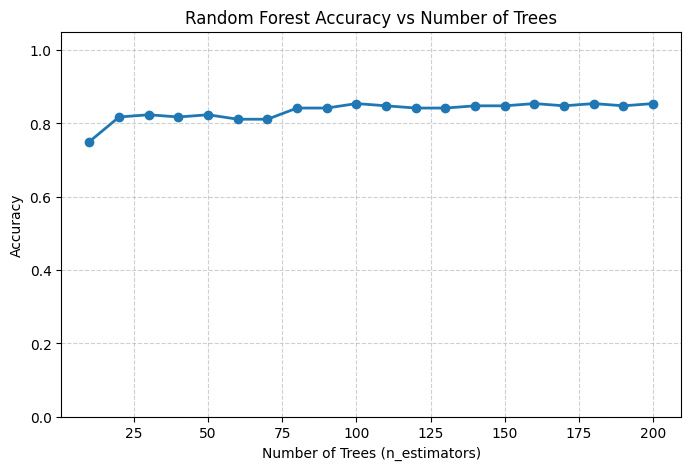

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_forest_accuracy(trees, accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(trees, accuracies, marker='o', linewidth=2)
    plt.title("Random Forest Accuracy vs Number of Trees")
    plt.xlabel("Number of Trees (n_estimators)")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(0, 1.05)
    plt.show()

accuracies = []
for i in tqdm(range(10, 201, 10)):
    x, y, tx, ty = get_sets(10)
    rf = get_model(x, y, i)
    accuracies.append(get_accuracy(rf, tx, ty))
plot_forest_accuracy([i for i in range(10, 201, 10)], accuracies)

In [11]:
print(f"Best accuracy: {max(accuracies)} for trees {accuracies.index(max(accuracies))}")

Best accuracy: 0.8536585365853658 for trees 9


3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?


### Answer:

My guess is that overfitting would improve classification on this specific image set, but when new images were added, the performance would collapse. 

*You can use this markdown cell to write down your thoughts.*

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [12]:
import numpy as np

def get_random_indices_with_val(seed=13540, total_images=1020, train_ratio=0.8, val_ratio=0.1):
    np.random.seed(seed)
    indices = np.random.permutation(total_images)

    n_train = int(total_images * train_ratio)
    n_val = int(total_images * val_ratio)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    return train_indices, val_indices, test_indices


def get_sets_with_val(seed=13540):
    tr_i, val_i, tst_i = get_random_indices_with_val(seed)
    return (
        img_arrays[tr_i], labels[tr_i],
        img_arrays[val_i], labels[val_i],
        img_arrays[tst_i], labels[tst_i]
    )


In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

val_accuracies = []
test_accuracies = []
models = [rf]
for i in tqdm(range(10, 201, 10)):
    x, y, vx, vy, tx, ty = get_sets_with_val(10)
    rf = get_model(x, y, i)
    val_accuracies.append(get_accuracy(rf, vx, vy))
    test_accuracies.append(get_accuracy(rf, tx, ty))


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


In [14]:
print(f"Best validation accuracy: {max(val_accuracies)} for trees {10 + 10*val_accuracies.index(max(val_accuracies))}")
best = val_accuracies.index(max(val_accuracies))
print(f"Test accuracy with best validation model: {test_accuracies[best]}")

print(f"Best Test accuracy: {max(test_accuracies)} for trees {10 + 10*test_accuracies.index(max(test_accuracies))}")

Best validation accuracy: 0.8333333333333334 for trees 200
Test accuracy with best validation model: 0.8823529411764706
Best Test accuracy: 0.8823529411764706 for trees 190


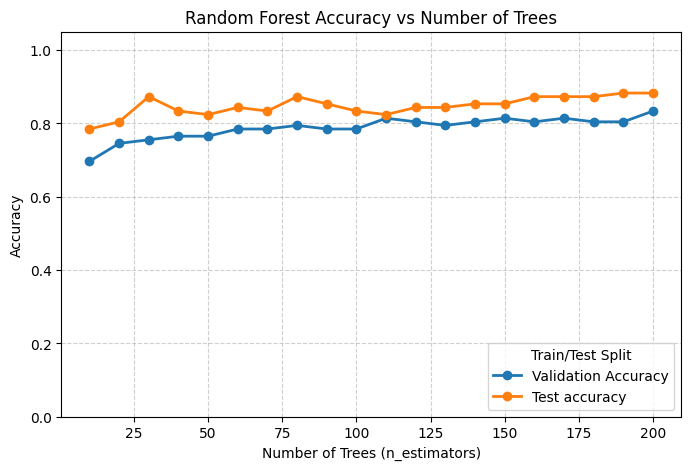

In [15]:
def plot_forest_accuracy_with_val(trees, accuracies, t_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(trees, accuracies, marker='o', linewidth=2, label = "Validation Accuracy")
    plt.plot(trees, t_accuracies, marker='o', linewidth=2, label = "Test accuracy")
    plt.title("Random Forest Accuracy vs Number of Trees")
    plt.xlabel("Number of Trees (n_estimators)")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(0, 1.05)
    plt.legend(title="Train/Test Split", loc="lower right", fontsize=10)
    plt.show()
plot_forest_accuracy_with_val([i for i in range(10, 201, 10)], val_accuracies, test_accuracies)


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 3 | TPOT

The process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [17]:
from tpot import TPOTClassifier

x, y, tx, ty = get_sets()

est = TPOTClassifier(
    generations=5,
    population_size=20,
    n_jobs=-1,
    random_state=42
)
# est.fit(x, y)


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

Unfortunately I couldn't get this working. I suspect this is due to my company laptop having some issues. I'm also on a trip and I might not be able get to my personal laptop in time to debug this.

Hopefully this is sufficient for the task.